## Problem Set 1 Question 2

First, we load libraries again, included in e.g. Conda python. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size

import numpy as np

## Implement the model


In [2]:
class iam():

    def __init__(self, σ=1, β=0.75, δ=0.5, α=1/3,
                a1 = 0.06, a2 = 2.8, b1 = 0.5, b2 = 2,
                γ = 0.13,
                φ = 0.06):
        'Parameters:'
        self.σ, self.β, self.δ, self.α, self.a1, self.a2, self.b1, self.b2, self.γ, self.φ = σ, β, δ, α, a1, a2, b1, b2, γ, φ
        
        'Endogenous outcomes and endogenous grid:'
        self.k0 = 0.1
        self.m0 = 0
        
        self.steadystate = self.ss()
        self.grid = self.create_grid()
        self.v_initial = self.v_initial()

    def u(self, c):
        'Utility function'
        σ = self.σ

        return c ** (1 - σ) / (1 - σ) if σ!= 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility'
        σ = self.σ

        return c ** (-σ)

    def f(self, k):
        'Production function'
        α = self.α

        return k ** α

    def f_prime(self, k):
        'Derivative of production function'
        α = self.α

        return α * k ** (α - 1)
    
    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α = self.α 

        return (k / α) ** (1 / (α - 1))

    def ss(self):
        'Define the steady-state equation s.t. RHS=0'
        β, δ = self.β, self.δ
        f_prime_inv = self.f_prime_inv
        
        return f_prime_inv(1/β - (1-δ))
    
    def create_grid(self):
        'Create a grid as prescribed in the assignment'
        n_k = 100j
        n_m = 100j
        k1, k_nk = 0.1, 0.4
        m1, m_nm = 1e-10, 0.5

        s = np.mgrid[k1:k_nk:n_k, m1:m_nm:n_m].reshape(2,-1).T

        return s
    
    def v_initial(self):
        'Create initialization for value function'
        grid = self.grid
        v_initial = np.zeros_like(self.grid[:,0])
        return v_initial      
    
    def state_action_value(self, k_new, m_new, k, m):
        'Method to evaluate the value of inst. consumption given a certain policy'
        #functions
        u, f = self.u, self.f
        #parameters
        β, δ, a1, a2, b1, b2, φ, γ, α = self.β, self.δ, self.a1, self.a2, self.b1, self.b2, self.φ, self.γ, self.α
        
        #write the RHS bellman eq. in separate, tractable parts
        mu_t = ((1-φ)*m - m_new)/(γ*(k**α)) + 1
        c_t = (1-a1*(mu_t**a2))/(1+b1*(m**b2))*k**α + (1-δ)*k - k_new
                
        return mu_t, c_t 
                                                  

## Implement the algorithm

In [3]:
# Edit this - restrictions on c(t) and mu(t) in the matrix
def u_mat(iam, v):
    grid = iam.grid
    #functions
    u, f = iam.u, iam.f
    #parameters
    β, δ, a1, a2, b1, b2, φ, γ, α = iam.β, iam.δ, iam.a1, iam.a2, iam.b1, iam.b2, iam.φ, iam.γ, iam.α
      
    u_out = np.zeros((len(iam.grid), len(iam.grid)))
    
    for i in range(len(grid)):
        
        for j in range(len(grid)):
            
            # rename the variables for convenience
            k_new, m_new = grid[j][0], grid[j][1]
            k, m = grid[i][0], grid[i][1]
            
            # Check feasibility and evaluate instantaneous utility       
            mu, c = iam.state_action_value(k_new, m_new, k, m)
            
            if (c > 0 and 0 <= mu <= 1):
                
                u_out[i,j] = u(c) + β*v[j]
            
            else:
                u_out[i,j] = -np.Inf
                   
    return u_out

In [5]:
initial_u = u_mat(iam(), iam().v_initial)

np.save("./initial_u", initial_u)

/home/bas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in double_scalars


In [75]:
#initial_u = np.load('./initial_u.npy')

In [6]:
initial_u

array([[-0.9511168 , -0.93558693, -0.92259842, ...,        -inf,
               -inf,        -inf],
       [       -inf, -0.95012257, -0.93475308, ...,        -inf,
               -inf,        -inf],
       [       -inf,        -inf, -0.94916727, ...,        -inf,
               -inf,        -inf],
       ...,
       [       -inf,        -inf,        -inf, ..., -0.81256404,
        -0.80624993, -0.80083746],
       [       -inf,        -inf,        -inf, ..., -0.82261421,
        -0.81537746, -0.80911326],
       [       -inf,        -inf,        -inf, ..., -0.83363663,
        -0.82540614, -0.81822261]])

In [7]:
def value_function_iteration(iam,
                             initial_matrix,
                             tol=1e-4,
                             max_iter=1000,
                             verbose=True,
                             print_skip=5):
    'Compute the value function through the fixed point of a contraction mapping'
    # Set up loop
    v = iam.v_initial # Initial guess
    initial_u = initial_matrix
    
    i = 0
    error = tol + 1
    
    while i < max_iter and error > tol:
        
        new_u = initial_u + iam.β*v
        v_new, km_new = np.max(new_u, axis=1), np.argmax(new_u, axis=1) #both k and m are contained in this index
        
        error = np.max(np.abs(v - v_new))
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
            
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new, km_new

In [9]:
v_conv, km_conv_index = value_function_iteration(iam(), initial_u)

Error at iteration 5 is 0.3066376040176211.
Error at iteration 10 is 0.07202092384118863.
Error at iteration 15 is 0.017040563445804402.
Error at iteration 20 is 0.004038417478848366.
Error at iteration 25 is 0.0009570618601122405.
Error at iteration 30 is 0.0002271152656323494.

Converged in 33 iterations.


## A Couple of Functions to Plot Policy

As per the assignment:

In [72]:
def plot_paths(iam, km_conv_index, T):
    'A function to plot optimal paths of K, M, c and mu'
    grid = iam.grid
    m = []
    k = []
    mu = []
    c = []
    
    k0 = grid.flat[np.abs(iam.grid - iam.k0).argmin()]
    m0 = grid.flat[np.abs(iam.grid - iam.m0).argmin()]
    
    k.append(k0)
    m.append(m0)
    
    for i in range(T):
        # State variables
        index = km_conv_index[np.all(grid == [k[i], m[i]], axis = 1)][0]
        k.append(grid[index][0])
        m.append(grid[index][1])
        
        # Control variables as a function of the state variables
        controls = iam.state_action_value(k[i+1], m[i+1], k[i], m[i])
        mu.append(controls[0])
        c.append(controls[1])
        
    # Create a quadruple plot
    fig, ax = plt.subplots(2, 2)
    ax[0,0].plot(range(T+1), k)
    ax[0,0].set_title('Policy Path Starting from $K_0$')
    
    ax[0,1].plot(range(T+1), m)
    ax[0,1].set_title('Emission Path Starting from $m_0$')
    
    ax[1,0].plot(range(T), mu)
    ax[1,0].set_title('Abatement Rate')
    
    ax[1,1].plot(range(T), c)
    ax[1,1].set_title('Consumption')
    
    fig.tight_layout(pad=3.0)
    
    plt.show()
    
    

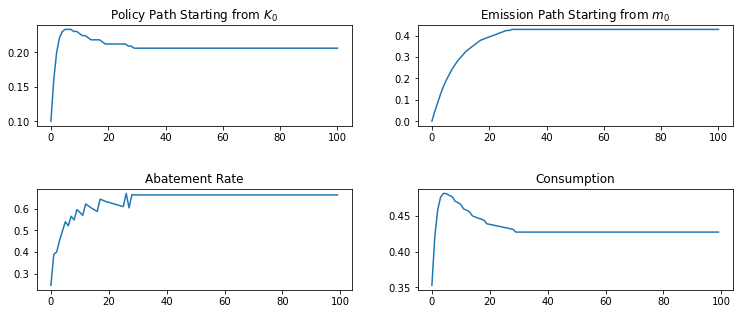

In [74]:
plot_paths(iam(), km_conv_index, 100)